<a href="https://colab.research.google.com/github/pravincoder/stock_bots/blob/main/Transformer_Close_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# Read Csv
import pandas as pd
data = pd.read_csv('drive/MyDrive/Nifty50(15-24).csv')

In [ ]:
data.head()

,Date,Open,High,Low,Close,Shares Traded,Turnover (₹ Cr)
0,2015-11-09,7788.25,7937.75,7771.70,7915.20,218422388.0,9376.17
1,2015-11-10,7877.60,7885.10,7772.85,7783.35,170267413.0,7153.47
2,2015-11-11,7838.80,7847.95,7819.10,7825.00,22380435.0,1123.44
3,2015-11-13,7762.45,7775.10,7730.90,7762.25,165876819.0,7731.55
4,2015-11-16,7732.95,7838.85,7714.15,7806.60,154134885.0,6871.15


In [ ]:
## Suggestion :- Can make a function for each step to use it on the go for multiple csv's

# Remove WhiteSpaces in Columns
data.columns = data.columns.str.strip()

# Check Null Values in Every Column
if data.isna().sum().all()==0:
    print('All Columns are Filled with Some values')


All Columns are Filled with Some values


In [ ]:
# Add Simple Moving Averages
data['SMA_5'] = data['Close'].rolling(window=5).mean()
data['SMA_20'] = data['Close'].rolling(window=20).mean()

# Add Exponential Moving Averages
data['EMA_5'] = data['Close'].ewm(span=5, adjust=False).mean()
data['EMA_20'] = data['Close'].ewm(span=20, adjust=False).mean()

# Add Volume-related Features
data['Avg_Volume_5'] = data['Shares Traded'].rolling(window=5).mean()
data['Volume_Ratio'] = data['Shares Traded'] / data['Avg_Volume_5']

# Add Volatility Features
data['Rolling_Std_5'] = data['Close'].rolling(window=5).std()
data['Bollinger_High'] = data['SMA_20'] + 2 * data['Rolling_Std_5']
data['Bollinger_Low'] = data['SMA_20'] - 2 * data['Rolling_Std_5']

# Add Momentum Indicators
data['Price_Change'] = data['Close'].pct_change()
data['RSI'] = 100 - (100 / (1 + data['Price_Change'].rolling(window=14).mean() / data['Price_Change'].rolling(window=14).std()))

# Define EMA_12 and EMA_26 for MACD calculation
data['EMA_12'] = data['Close'].ewm(span=12, adjust=False).mean()
data['EMA_26'] = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = data['EMA_12'] - data['EMA_26']

# Fill NaN values using Interpolation can be more accurate for time series data.
data.interpolate(method='linear', inplace=True)

# Fill any remaining NaNs using forward fill and backward fill
data.fillna(method='ffill', inplace=True)
data.fillna(method='bfill', inplace=True)

print(data.head(10))


         Date     Open     High      Low    Close  Shares Traded  \
0  2015-11-09  7788.25  7937.75  7771.70  7915.20    218422388.0   
1  2015-11-10  7877.60  7885.10  7772.85  7783.35    170267413.0   
2  2015-11-11  7838.80  7847.95  7819.10  7825.00     22380435.0   
3  2015-11-13  7762.45  7775.10  7730.90  7762.25    165876819.0   
4  2015-11-16  7732.95  7838.85  7714.15  7806.60    154134885.0   
5  2015-11-17  7848.75  7860.45  7793.00  7837.55    149451211.0   
6  2015-11-18  7823.15  7843.40  7725.05  7731.80    148037721.0   
7  2015-11-19  7788.50  7854.90  7765.45  7842.75    136702518.0   
8  2015-11-20  7841.90  7906.95  7817.80  7856.55    156610433.0   
9  2015-11-23  7869.50  7877.50  7825.20  7849.25    130871603.0   

   Turnover (₹ Cr)    SMA_5     SMA_20        EMA_5  ...  Avg_Volume_5  \
0          9376.17  7818.48  7840.1525  7915.200000  ...   146216388.0   
1          7153.47  7818.48  7840.1525  7871.250000  ...   146216388.0   
2          1123.44  7818.48  

In [ ]:
# Drop Date Column
X = data.drop(['Date'],axis=1)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[X.columns.values])


In [ ]:
# Fit a separate scaler for the Close prices
close_scaler = MinMaxScaler()
close_scaler.fit(data[['Close']])

MinMaxScaler()

In [ ]:
data.iloc[:,4]

0        7915.20
1        7783.35
2        7825.00
3        7762.25
4        7806.60
          ...   
2143    24320.55
2144    24433.20
2145    24324.45
2146    24315.95
2147    24502.15
Name: Close, Length: 2148, dtype: float64

In [ ]:
import numpy as np

def create_sequences(data, time_steps=5):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps, 3])  # Close price
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data)

In [ ]:
# Split into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
print(X_train.shape[1:])

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define Transformer Model
def create_transformer_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)

    # Transformer Encoder
    for _ in range(8):  # Number of layers
        x = layers.MultiHeadAttention(num_heads=8, key_dim=128)(x, x)
        x = layers.LayerNormalization(epsilon=1e-6)(x + inputs)

        x = layers.Conv1D(filters=64, kernel_size=1, activation='relu')(x)
        x = layers.Conv1D(filters=input_shape[-1], kernel_size=1)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x + inputs)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(1)(x)

    model = keras.Model(inputs, outputs)
    return model

In [ ]:
# Create and compile the model
model = create_transformer_model(X_train.shape[1:])
model.compile(optimizer='adam', loss='mse')

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=40, batch_size=16, validation_split=0.2)

Epoch 1/80
86/86 [==============================] - 29s 134ms/step - loss: 0.0115 - val_loss: 0.0091
Epoch 2/80
86/86 [==============================] - 11s 134ms/step - loss: 0.0011 - val_loss: 0.0054
Epoch 3/80
86/86 [==============================] - 13s 146ms/step - loss: 9.5800e-04 - val_loss: 0.0103
Epoch 4/80
86/86 [==============================] - 12s 143ms/step - loss: 8.7194e-04 - val_loss: 0.0038
Epoch 5/80
86/86 [==============================] - 9s 107ms/step - loss: 8.1571e-04 - val_loss: 0.0018
Epoch 6/80
86/86 [==============================] - 11s 123ms/step - loss: 8.5171e-04 - val_loss: 0.0021
Epoch 7/80
86/86 [==============================] - 14s 158ms/step - loss: 7.9724e-04 - val_loss: 0.0076
Epoch 8/80
86/86 [==============================] - 12s 138ms/step - loss: 0.0013 - val_loss: 0.0051
Epoch 9/80
86/86 [==============================] - 21s 243ms/step - loss: 7.8690e-04 - val_loss: 0.0038
Epoch 10/80
86/86 [==============================] - 13s 149ms/step 

In [ ]:
# Make predictions
y_pred = model.predict(X_test)
# Inverse transform to get original scale using close_scaler
y_pred_inverse = close_scaler.inverse_transform(y_pred)
y_test_inverse = close_scaler.inverse_transform(y_test.reshape(-1, 1))


14/14 [==============================] - 1s 25ms/step


In [ ]:


predictions_df = pd.DataFrame({
    'Date': data['Date'][train_size + 5:].reset_index(drop=True),
    'Actual Close': y_test_inverse.flatten(),
    'Predicted Close': y_pred_inverse.flatten()
})

# Save to CSV
#predictions_df.to_csv('predictions.csv', index=False)


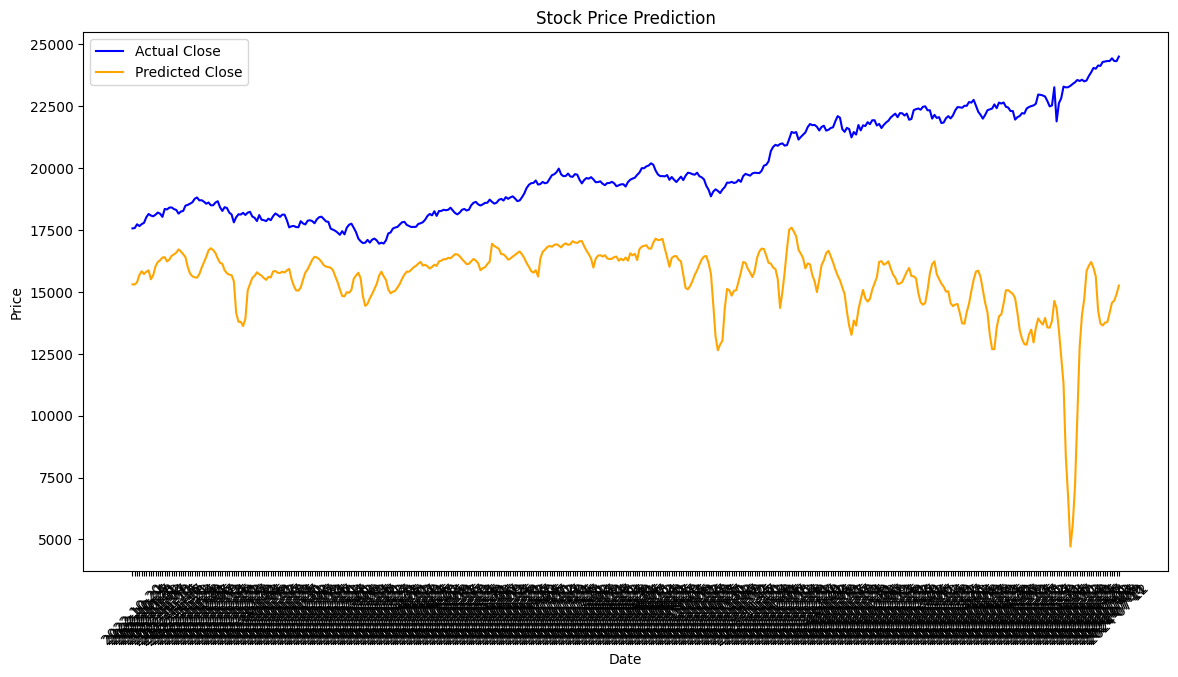

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(predictions_df['Date'], predictions_df['Actual Close'], label='Actual Close', color='blue')
plt.plot(predictions_df['Date'], predictions_df['Predicted Close'], label='Predicted Close', color='orange')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [ ]:
# Predict the next year's data
last_sequence = X_test[-1]
future_predictions = []

for _ in range(10):  # Assuming 365 trading days
    next_pred = model.predict(last_sequence[np.newaxis, :, :])
    future_predictions.append(next_pred[0, 0])

    next_pred_scaled = close_scaler.transform(next_pred)
    new_sequence = np.append(last_sequence[1:], [scaled_data[-1][:20] + [next_pred_scaled[0, 0]]], axis=0)
    last_sequence = new_sequence

1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 24ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 32ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 26ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [ ]:
# Inverse transform future predictions
future_predictions_inverse = close_scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
# Create a date range for future predictions
last_date = pd.to_datetime(data['Date'].iloc[-1])
future_dates = pd.date_range(last_date, periods=10, freq='B')

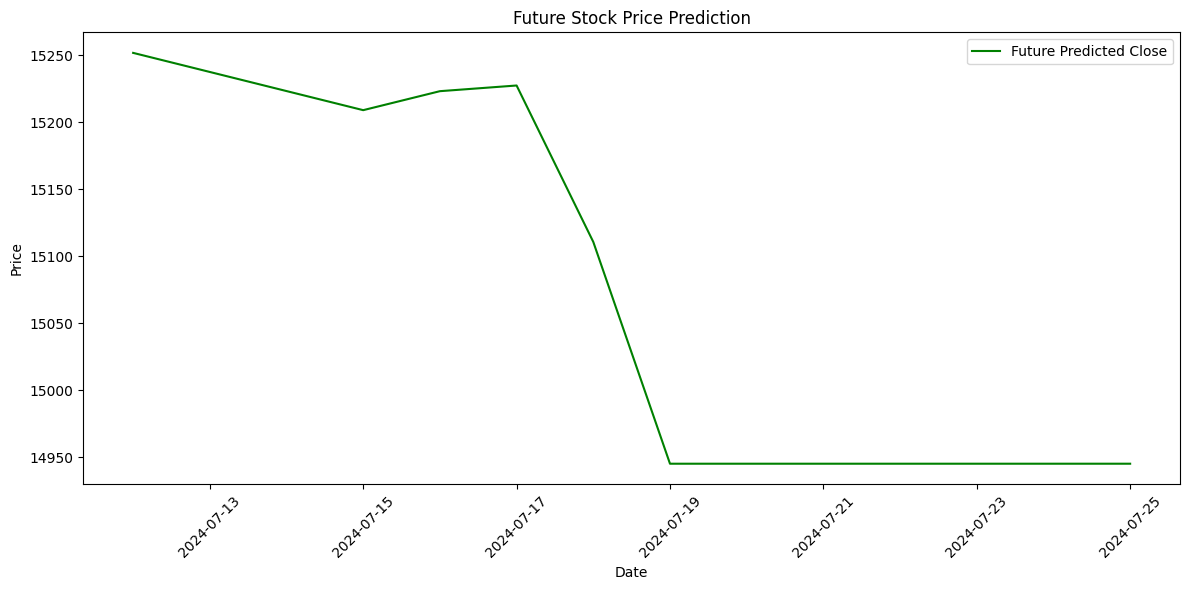

In [ ]:
# Plot the future predictions
plt.figure(figsize=(12, 6))
plt.plot(future_dates, future_predictions_inverse, color='green', label='Future Predicted Close')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Future Stock Price Prediction')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=data['Date'],
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close'])] )


fig.show()